In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Increase the default sizes of all labels:

In [2]:
import matplotlib.pylab as pylab

params = {'axes.labelsize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'legend.fontsize': 'x-large'}
pylab.rcParams.update(params)

In [3]:
A_MAX = 1.0
A_MIN = -1.0
DAYS = 7
PERIOD = 24*DAYS
START=0

In [4]:
df_kpi = pd.read_csv(r'20 bin PPO 500 results\KPIs.csv',
                     usecols=['cost_function','untargeted_binary_myPGD_05'],
                     index_col=0)
df_kpi['Bifurcated_ACG'] = pd.read_csv(r'20 bin PPO 500 results\binary classifier uACG results\KPIs.csv',
                     usecols=['uACG CWloss 5% eps']).values

myPGD outperformed ACG despite being a weaker attack, and this is also true for the discrete agent

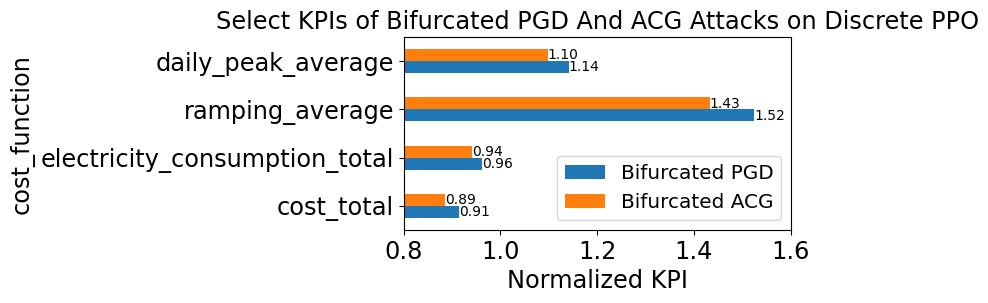

In [5]:
kpi_to_plot = ['cost_total', 'electricity_consumption_total','ramping_average','daily_peak_average']
ax = df_kpi.loc[kpi_to_plot].plot.barh(
                  ylabel='KPI',
                  title='Select KPIs of Bifurcated PGD And ACG Attacks on Discrete PPO',
                  xlim=0.8,
                  figsize=(5,2.5),
                  )
ax.set_xlabel('Normalized KPI')
ax.legend(['Bifurcated PGD', 'Bifurcated ACG'],
          #bbox_to_anchor=(1.0, 0.6),
          )
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f')

In [6]:
df_a = pd.DataFrame({})
df_a['myPGD_clean_actions'] = pd.read_csv(r'20 bin PPO 500 results\untargeted_binary_myPGD_05_obs-a.csv',
            usecols=['a'])
df_a['myPGD_adv_actions'] = pd.read_csv(r'20 bin PPO 500 results\untargeted_binary_myPGD_05_adv_obs-a.csv',
            usecols=['a'])
df_a['ACG_clean_actions'] = pd.read_csv(r'20 bin PPO 500 results\binary classifier uACG results\uACG CWloss 5% eps a-obs.csv',
            usecols=['a'])
df_a['ACG_adv_actions'] = pd.read_csv(r'20 bin PPO 500 results\binary classifier uACG results\uACG CWloss 5% eps adv a-obs.csv',
            usecols=['a'])


Transform action space [0,1] -> [-1,1]

In [7]:
df_a.replace(dict(
                enumerate(
                    np.linspace(A_MIN,A_MAX,20)
                    )
                ),
            inplace=True)

Stats:

In [8]:
print(f'The ASR for the myPGD attack is {format((df_a["myPGD_clean_actions"] != df_a["myPGD_adv_actions"]).mean(), ".3f")}')
print(f'The ASR for the ACG attack is {format((df_a["ACG_clean_actions"] != df_a["ACG_adv_actions"]).mean(), ".3f")}')

The ASR for the myPGD attack is 0.628
The ASR for the ACG attack is 0.366


# WTF?!?!?!?!?

- Is the ASR difference from the extra restarts? Early Stopping? 
- Maybe try a run using the model's predictions instead of actions for y?
- would APGD work better? Maybe the CG is at fault?

In [9]:
myPGD_decision_flip = (np.sign(df_a['myPGD_clean_actions']) != np.sign(df_a['myPGD_adv_actions'])).mean()
ACG_decision_flip = (np.sign(df_a['ACG_clean_actions']) != np.sign(df_a['ACG_adv_actions'])).mean()
print(f'The (dis)charge was reversed {format(myPGD_decision_flip, ".3f")} of the time for the myPGD attack, \
       compared to {format(ACG_decision_flip, ".3f")} for ACG. ACG was {format(ACG_decision_flip/myPGD_decision_flip, ".3f")} times as effective')


The (dis)charge was reversed 0.261 of the time for the myPGD attack,        compared to 0.212 for ACG. ACG was 0.812 times as effective


In [10]:
myPGD_sign_flip_from_prev = (np.sign(df_a['myPGD_adv_actions']) != np.sign(df_a['myPGD_adv_actions'].shift())).mean()
myPGD_sign_flip_from_prev = (np.sign(df_a['ACG_adv_actions']) != np.sign(df_a['ACG_adv_actions'].shift())).mean()
print(f'The (dis)charge was reversed between two timesteps {format(myPGD_sign_flip_from_prev, ".3f")} of the time for the myPGD attack, \
       compared to {format(myPGD_sign_flip_from_prev, ".3f")} for ACG. ACG was {format(myPGD_sign_flip_from_prev/myPGD_sign_flip_from_prev, ".3f")} times as effective')

The (dis)charge was reversed between two timesteps 0.207 of the time for the myPGD attack,        compared to 0.207 for ACG. ACG was 1.000 times as effective


In [11]:
print(f'MAE for transformed discrete myPGD attack:{format((df_a["myPGD_clean_actions"] - df_a["myPGD_adv_actions"]).abs().mean(), ".3f")}')
print(f'MAE for transformed ACG attack actions:{format((df_a["ACG_clean_actions"] - df_a["ACG_adv_actions"]).abs().mean(), ".3f")}')

MAE for transformed discrete myPGD attack:0.266
MAE for transformed ACG attack actions:0.178


ACG outperforms myPGD on all the metrics above. It seems to adhere best to the GDL surrogate loss function, which may indicate this loss function is sub-optimal. If the effect is reproduced for the discrete agent, this is the likely cause

In [12]:
myPGD_mask = df_a.columns[df_a.columns.str.contains('myPGD')]
ACG_mask = df_a.columns[df_a.columns.str.contains('ACG')]

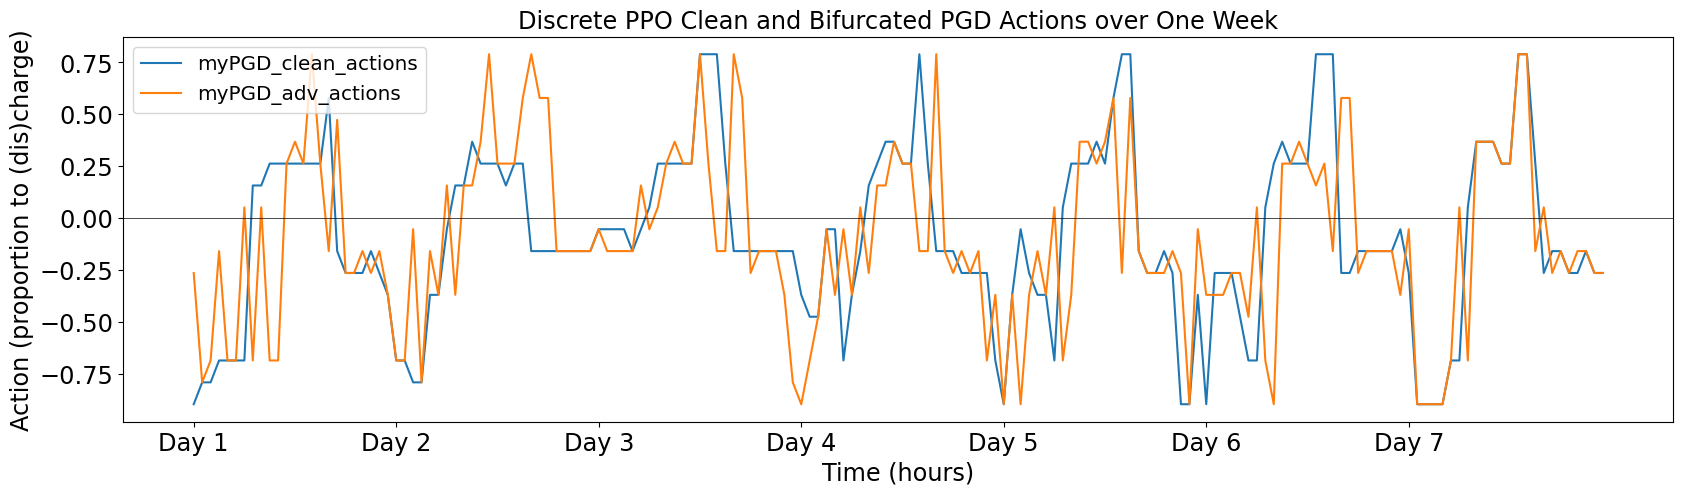

In [13]:
start = 0*7*24
df_a[myPGD_mask].iloc[start:start+PERIOD].plot.line(
        figsize=(20,5),
    ylabel='Action (proportion to (dis)charge)',
    title='Discrete PPO Clean and Bifurcated PGD Actions over One Week',
    xlabel='Time (hours)',
    ).set_xticks(ticks=range(0,PERIOD,24),
                 labels=['Day ' + str(i+1) for i in range(DAYS)])
plt.axhline(0, color='black', linewidth=0.5)

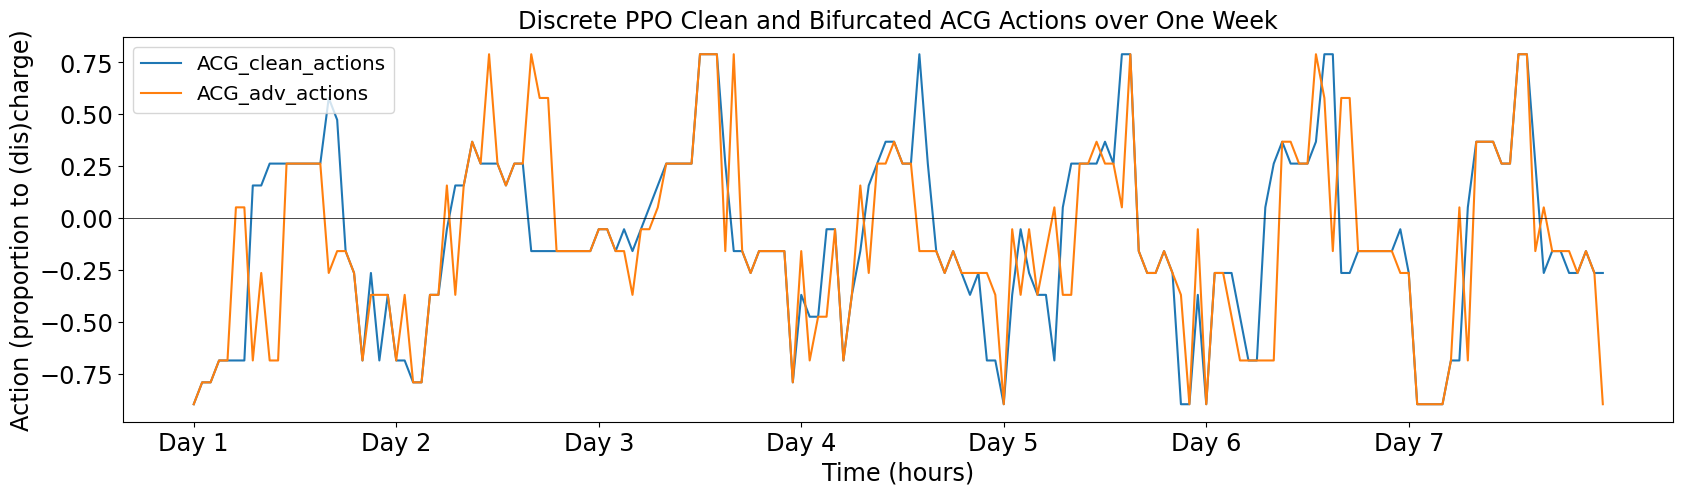

In [14]:
start = 0*7*24
df_a[ACG_mask].iloc[start:start+PERIOD].plot.line(
        figsize=(20,5),
    ylabel='Action (proportion to (dis)charge)',
    title='Discrete PPO Clean and Bifurcated ACG Actions over One Week',
    xlabel='Time (hours)'
    ).set_xticks(ticks=range(0,PERIOD,24),
                 labels=['Day ' + str(i+1) for i in range(DAYS)])
plt.axhline(0, color='black', linewidth=0.5)

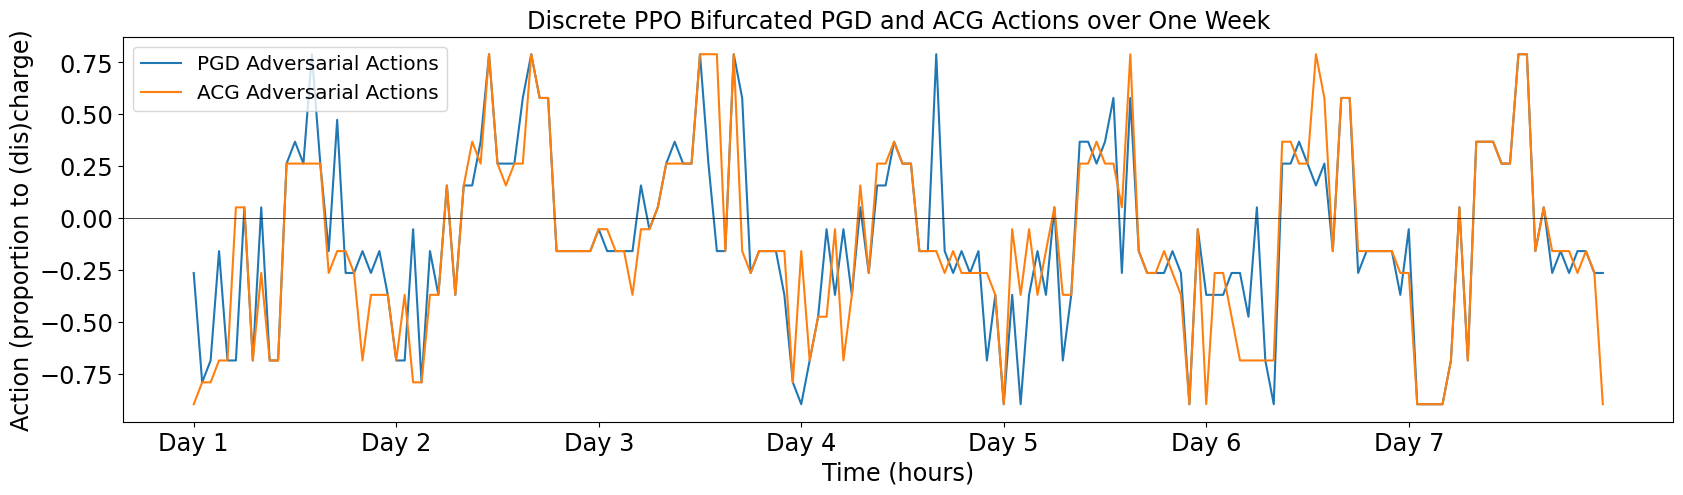

In [15]:
start = 0*7*24
ax = df_a[['myPGD_adv_actions','ACG_adv_actions']].iloc[start:start+PERIOD].plot.line(
        figsize=(20,5),
    ylabel='Action (proportion to (dis)charge)',
    title='Discrete PPO Bifurcated PGD and ACG Actions over One Week',
    xlabel='Time (hours)'
    )
ax.set_xticks(ticks=range(0,PERIOD,24),
                 labels=['Day ' + str(i+1) for i in range(DAYS)])
ax.legend(['PGD Adversarial Actions','ACG Adversarial Actions'])
plt.axhline(0, color='black', linewidth=0.5)

From this plot (during this week), myPGD fully charges then fully discharges more than ACG. Maybe this is why it uses more power? Can I take the integral/sum of the actions to check?

Text(0.5, 0, '(Dis)charge Action')

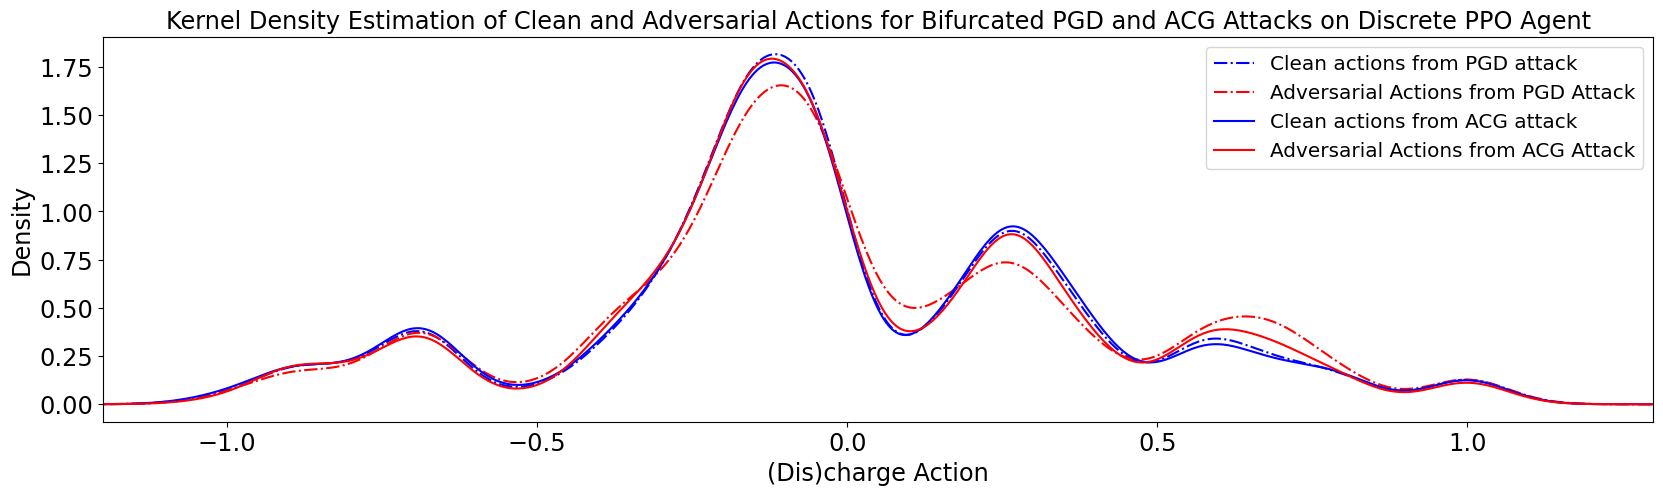

In [16]:
ax = df_a.plot.kde(
    figsize=(20,5),
    xlim=(-1.2,1.3),
    xlabel='(Dis)harge Action',
    title='Kernel Density Estimation of Clean and Adversarial Actions for Bifurcated PGD and ACG Attacks on Discrete PPO Agent',
    style=['b-.','r-.','b-','r-'],
)
ax.legend(['Clean actions from PGD attack', 'Adversarial Actions from PGD Attack','Clean actions from ACG attack', 'Adversarial Actions from ACG Attack'])
ax.set_xlabel('(Dis)charge Action')

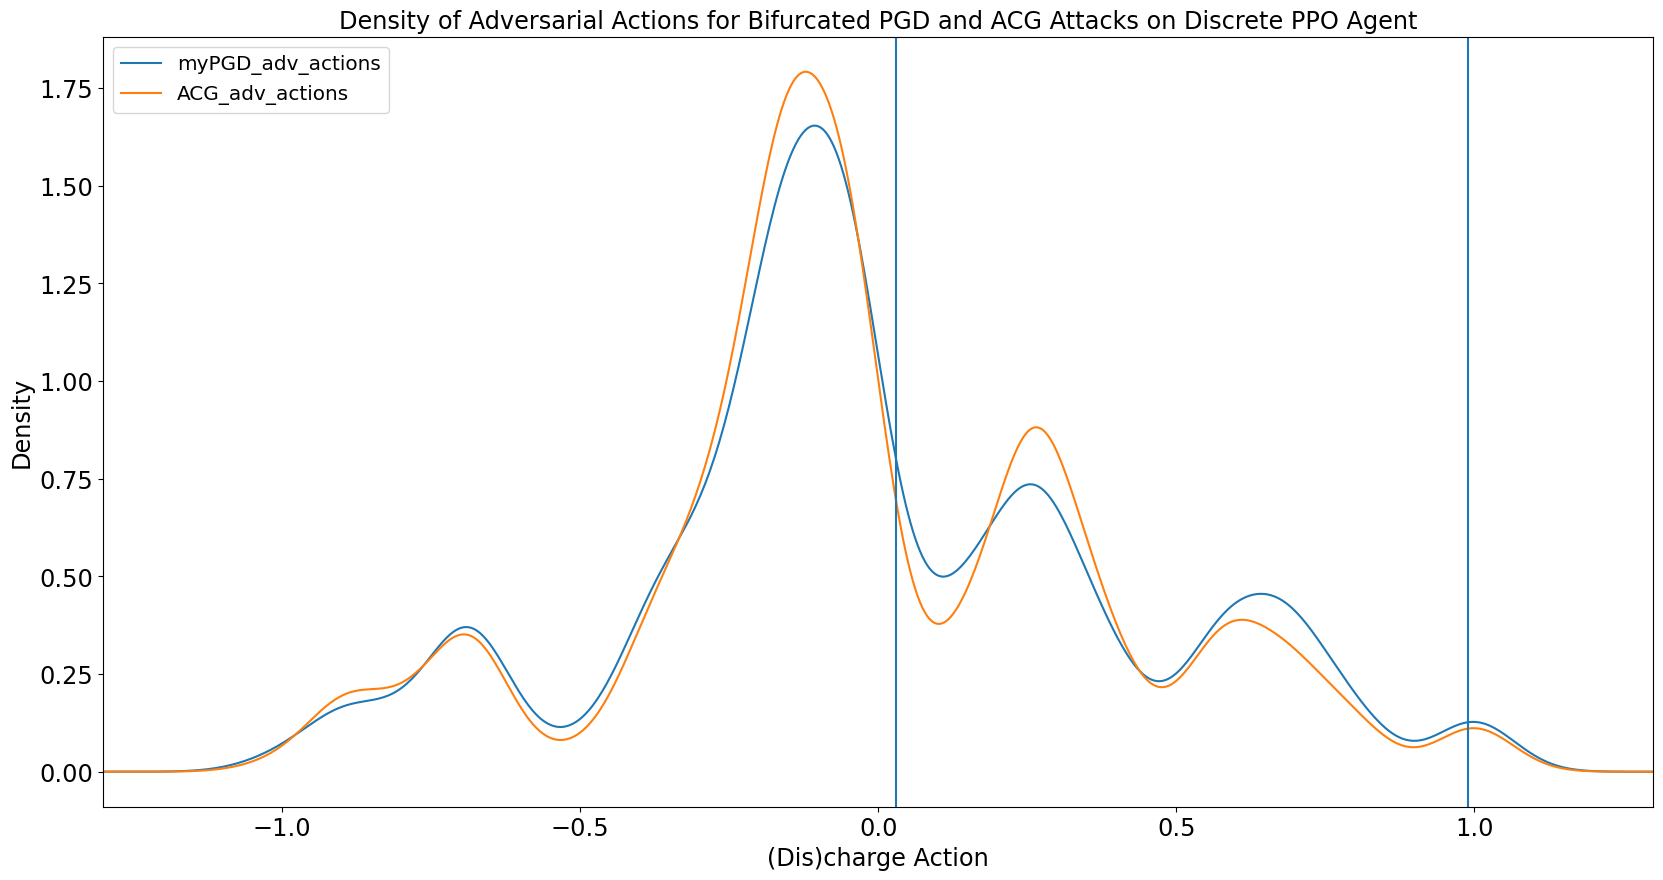

In [17]:
ax = df_a[['myPGD_adv_actions','ACG_adv_actions']].plot.kde(
    figsize=(20,10),
    xlim=(-1.3,1.3),
    xlabel='(Dis)harge Action',
    title='Density of Adversarial Actions for Bifurcated PGD and ACG Attacks on Discrete PPO Agent'
)
ax.set_xlabel('(Dis)charge Action')
plt.axvline(0.99)
plt.axvline(0.03)

Overall, we see very different distirbutions between the attacks, which explains the different KPIs. The surrogate loss function provided by the bifurcation layer may not be optimal, given that the weaker attack performed best.

In [18]:
df_a[['myPGD_adv_actions','ACG_adv_actions']].mean()

myPGD_adv_actions   -0.003960
ACG_adv_actions     -0.018597
dtype: float64

myPGD is biased towards discraging from the mean, whereas ACG is much closer to a no action with a slight bias towards charging. FUrthermore, we see that myPGD does fully charge occaisionally

In [19]:
(df_a[['myPGD_adv_actions','ACG_adv_actions']] > 0.9).mean()

myPGD_adv_actions    0.021464
ACG_adv_actions      0.018153
dtype: float64

In [20]:
(df_a[['myPGD_adv_actions','ACG_adv_actions']] < -0.9).mean()

myPGD_adv_actions    0.005594
ACG_adv_actions      0.003653
dtype: float64

In [21]:
(df_a[['myPGD_adv_actions','ACG_adv_actions']] < 0).describe()

,myPGD_adv_actions,ACG_adv_actions
count,8759,8759
unique,2,2
top,True,True
freq,5405,5604


In [22]:
df_a[['myPGD_adv_actions','ACG_adv_actions']][df_a[['myPGD_adv_actions','ACG_adv_actions']] < 0].describe()

,myPGD_adv_actions,ACG_adv_actions
count,5405.000000,5604.000000
mean,-0.264696,-0.258274
std,0.248321,0.244810
min,-1.000000,-1.000000
25%,-0.368421,-0.368421
50%,-0.157895,-0.157895
75%,-0.052632,-0.052632
max,-0.052632,-0.052632


In [23]:
df_a[['myPGD_adv_actions','ACG_adv_actions']][df_a[['myPGD_adv_actions','ACG_adv_actions']] > 0].describe()

,myPGD_adv_actions,ACG_adv_actions
count,3354.000000,3155.000000
mean,0.416219,0.407123
std,0.260528,0.242024
min,0.052632,0.052632
25%,0.263158,0.263158
50%,0.368421,0.263158
75%,0.578947,0.578947
max,1.000000,1.000000
